## summary

* 2.5d segmentation
    *  segmentation_models_pytorch 
    *  Unet
* use only 6 slices in the middle
* slide inference

In [1]:
# !pip install -q ../input/pytorch-segmentation-models-lib/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4
# !pip install -q ../input/pytorch-segmentation-models-lib/efficientnet_pytorch-0.6.3/efficientnet_pytorch-0.6.3
# !pip install -q ../input/pytorch-segmentation-models-lib/timm-0.4.12-py3-none-any.whl
# !pip install -q ../input/pytorch-segmentation-models-lib/segmentation_models_pytorch-0.2.0-py3-none-any.whl

In [2]:
# !mkdir -p /root/.cache/torch/hub/checkpoints/
# !cp ../input/efficientnet-b0-355c32eb.pth /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth

In [3]:
# !pip install torch==1.10.2+cu113 torchvision==0.11.3+cu113 torchaudio===0.10.2+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [4]:

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, log_loss
import pickle
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import warnings
import sys
import pandas as pd
import os
import gc
import sys
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
import cv2

import scipy as sp
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from functools import partial

import argparse
import importlib
import torch
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW

import datetime

In [5]:
# sys.path.append('/kaggle/input/pretrainedmodels/pretrainedmodels-0.7.4')
# sys.path.append('/kaggle/input/efficientnet-pytorch/EfficientNet-PyTorch-master')
# sys.path.append('/kaggle/input/timm-pytorch-image-models/pytorch-image-models-master')
# sys.path.append('/kaggle/input/segmentation-models-pytorch/segmentation_models.pytorch-master')

In [6]:
import segmentation_models_pytorch as smp

In [7]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

## config

In [8]:
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2

class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'

    # comp_dir_path = './'
    comp_dir_path = '../input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'
    # comp_dataset_path = f'{comp_dir_path}datasets/{comp_folder_name}/'
    comp_dataset_path = f'{comp_dir_path}{comp_folder_name}/'
    
    exp_name = 'resnet-exp027'#'vesuvius_2d_slide_exp002'

    # ============== pred target =============
    target_size = 1

    # ============== model cfg =============
    model_name = 'Unet'
    # backbone = 'efficientnet-b0'
    # backbone = 'se_resnext101_32x4d'
    #backbone = 'se_resnext50_32x4d'
    #backbone = 'timm-resnest50d'
    backbone = 'timm-skresnext50_32x4d'

    in_chans = 6 # 65
    # ============== training cfg =============
    size = 256 #224
    tile_size = 256 #224
    stride = tile_size // 2

    train_batch_size = 16 # 32
    valid_batch_size = train_batch_size * 2
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'
    epochs = 30 # 15

    # adamW warmupあり
    warmup_factor = 10
    # lr = 1e-4 / warmup_factor
    lr = 1e-4 / warmup_factor

    # ============== fold =============
    valid_id = 1

    # objective_cv = 'binary'  # 'binary', 'multiclass', 'regression'
    metric_direction = 'maximize'  # maximize, 'minimize'
    # metrics = 'dice_coef'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 4

    seed = 42

    # ============== set dataset path =============
    print('set dataset path')

    outputs_path = f'../output/{comp_name}/{exp_name}/'

    submission_dir = outputs_path + 'submissions/'
    submission_path = submission_dir + f'submission_{exp_name}.csv'

    model_dir = outputs_path + \
        f'{comp_name}-models/'

    figures_dir = outputs_path + 'figures/'

    log_dir = outputs_path + 'logs/'
    log_path = log_dir + f'{exp_name}.txt'

    # ============== augmentation =============
    train_aug_list = [ #https://www.kaggle.com/competitions/hubmap-kidney-segmentation/discussion/238013
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(size, size),
        A.HorizontalFlip(),
        A.VerticalFlip(),
        A.RandomRotate90(),
        A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=0.9,
                         border_mode=cv2.BORDER_REFLECT),
        A.OneOf([
            A.ElasticTransform(p=.3),
            A.GaussianBlur(p=.3),
            A.GaussNoise(p=.3),
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(p=.1),
            A.IAAPiecewiseAffine(p=0.3),
        ], p=0.3),
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3,p=0.3),
        # A.Cutout(max_h_size=int(size * 0.6),
        #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]


set dataset path


/opt/conda/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:299: FutureWarning: This IAAPiecewiseAffine is deprecated. Please use PiecewiseAffine instead
  warnings.warn("This IAAPiecewiseAffine is deprecated. Please use PiecewiseAffine instead", FutureWarning)


## helper

In [9]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [10]:
def init_logger(log_file):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

def set_seed(seed=None, cudnn_deterministic=True):
    if seed is None:
        seed = 42

    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic
    torch.backends.cudnn.benchmark = False

In [11]:
def make_dirs(cfg):
    for dir in [cfg.model_dir, cfg.figures_dir, cfg.submission_dir, cfg.log_dir]:
        os.makedirs(dir, exist_ok=True)

In [12]:
def cfg_init(cfg, mode='train'):
    set_seed(cfg.seed)
    # set_env_name()
    # set_dataset_path(cfg)

    if mode == 'train':
        make_dirs(cfg)

In [13]:
cfg_init(CFG)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Logger = init_logger(log_file=CFG.log_path)

Logger.info('\n\n-------- exp_info -----------------')
# Logger.info(datetime.datetime.now().strftime('%Y年%m月%d日 %H:%M:%S'))



-------- exp_info -----------------


## image, mask

In [14]:
def read_image_mask(fragment_id):

    images = []

    # idxs = range(65)
    mid = 65 // 2
    start = mid - CFG.in_chans // 2
    end = mid + CFG.in_chans // 2
    idxs = range(start, end)

    for i in tqdm(idxs):
        
        image = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/surface_volume/{i:02}.tif", 0)

        pad0 = (CFG.tile_size - image.shape[0] % CFG.tile_size)
        pad1 = (CFG.tile_size - image.shape[1] % CFG.tile_size)

        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

        images.append(image)
    images = np.stack(images, axis=2)

    mask = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
    mask = np.pad(mask, [(0, pad0), (0, pad1)], constant_values=0)

    mask = mask.astype('float32')
    mask /= 255.0
    
    return images, mask

In [15]:
def get_train_valid_dataset():
    train_images = []
    train_masks = []

    valid_images = []
    valid_masks = []
    valid_xyxys = []

    for fragment_id in range(1, 4):

        image, mask = read_image_mask(fragment_id)

        x1_list = list(range(0, image.shape[1]-CFG.tile_size+1, CFG.stride))
        y1_list = list(range(0, image.shape[0]-CFG.tile_size+1, CFG.stride))

        for y1 in y1_list:
            for x1 in x1_list:
                y2 = y1 + CFG.tile_size
                x2 = x1 + CFG.tile_size
                # xyxys.append((x1, y1, x2, y2))
        
                if fragment_id == CFG.valid_id:
                    valid_images.append(image[y1:y2, x1:x2])
                    valid_masks.append(mask[y1:y2, x1:x2, None])

                    valid_xyxys.append([x1, y1, x2, y2])
                else:
                    train_images.append(image[y1:y2, x1:x2])
                    train_masks.append(mask[y1:y2, x1:x2, None])

    return train_images, train_masks, valid_images, valid_masks, valid_xyxys

In [16]:
train_images, train_masks, valid_images, valid_masks, valid_xyxys = get_train_valid_dataset()

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [17]:
# valid_xyxys = np.stack(valid_xyxys)

## dataset

In [18]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

In [19]:
def get_transforms(data, cfg):
    if data == 'train':
        aug = A.Compose(cfg.train_aug_list,p=1.0)
    elif data == 'valid':
        aug = A.Compose(cfg.valid_aug_list,p=1.0)

    # print(aug)
    return aug

class CustomDataset(Dataset):
    def __init__(self, images, cfg, labels=None, transform=None):
        self.images = images
        self.cfg = cfg
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # return len(self.df)
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            data = self.transform(image=image, mask=label)
            image = data['image']
            label = data['mask']

        return image, label

In [20]:

train_dataset = CustomDataset(
    train_images, CFG, labels=train_masks, transform=get_transforms(data='train', cfg=CFG))
valid_dataset = CustomDataset(
    valid_images, CFG, labels=valid_masks, transform=get_transforms(data='valid', cfg=CFG))

train_loader = DataLoader(train_dataset,
                          batch_size=CFG.train_batch_size,
                          shuffle=True,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True,
                          )
valid_loader = DataLoader(valid_dataset,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)


In [21]:
train_dataset[0][0].shape

torch.Size([6, 256, 256])

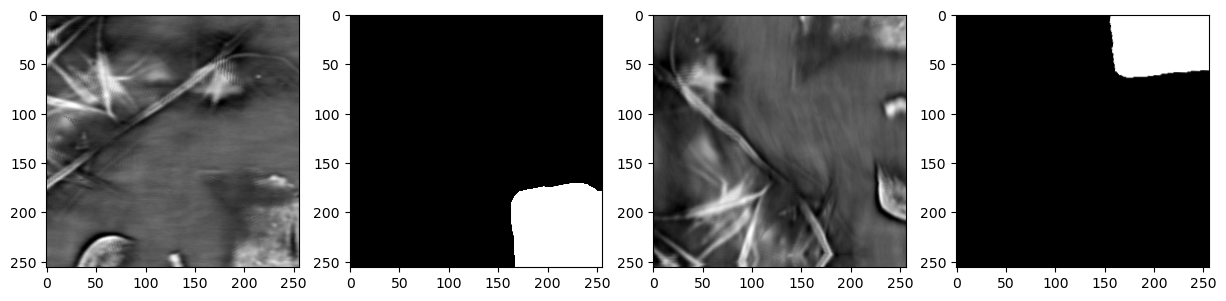

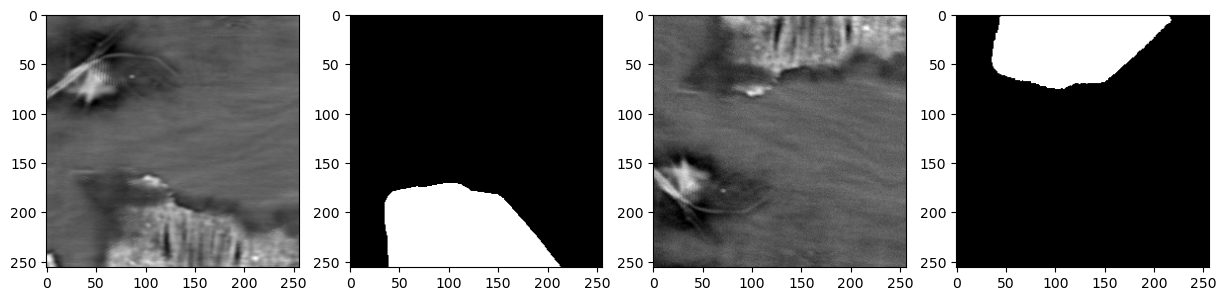

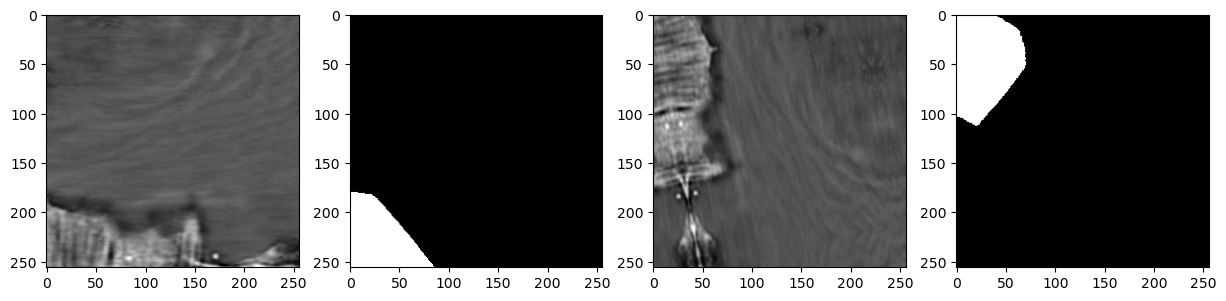

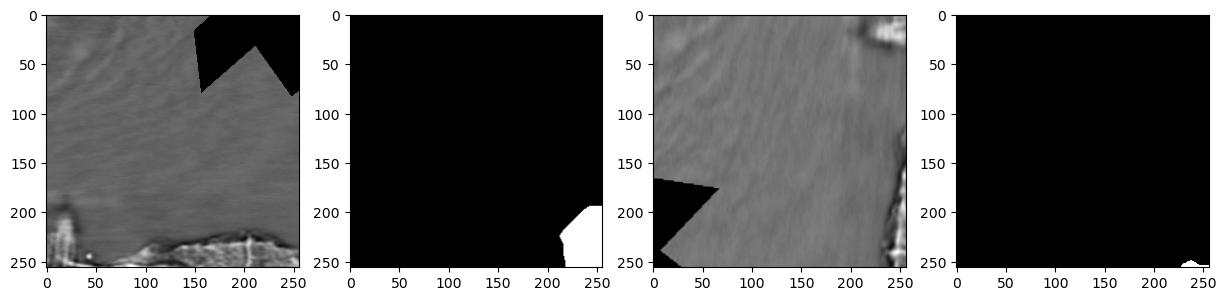

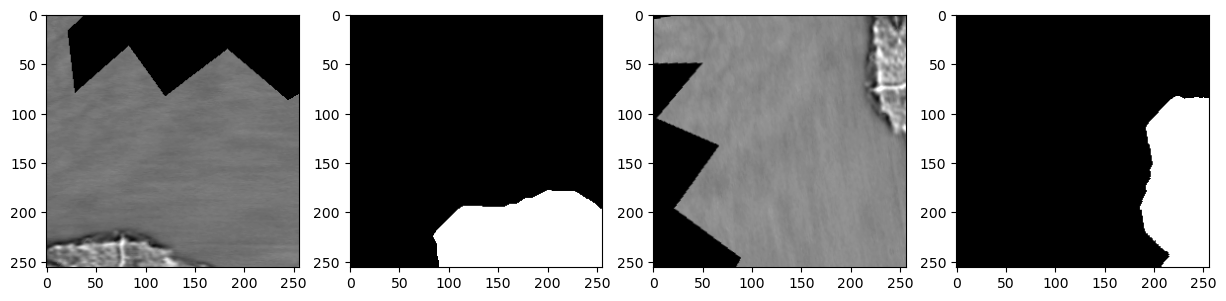

In [22]:

plot_dataset = CustomDataset(
    train_images, CFG, labels=train_masks)

transform = CFG.train_aug_list
transform = A.Compose(
    [t for t in transform if not isinstance(t, (A.Normalize, ToTensorV2))])


plot_count = 0
for i in range(1000):

    image, mask = plot_dataset[i]
    data = transform(image=image, mask=mask)
    aug_image = data['image']
    aug_mask = data['mask']

    if mask.sum() == 0:
        continue

    fig, axes = plt.subplots(1, 4, figsize=(15, 8))
    axes[0].imshow(image[..., 0], cmap="gray")
    axes[1].imshow(mask, cmap="gray")
    axes[2].imshow(aug_image[..., 0], cmap="gray")
    axes[3].imshow(aug_mask, cmap="gray")
    
    plt.savefig(CFG.figures_dir + f'aug_fold_{CFG.valid_id}_{plot_count}.png')

    plot_count += 1
    if plot_count == 5:
        break

In [23]:
del plot_dataset
gc.collect()

45691

## model

In [24]:
class CustomModel(nn.Module):
    def __init__(self, cfg, weight=None):
        super().__init__()
        self.cfg = cfg

        self.encoder = smp.Unet(
            encoder_name=cfg.backbone, 
            encoder_weights=weight,
            in_channels=cfg.in_chans,
            classes=cfg.target_size,
            activation=None,
        )

    def forward(self, image):
        output = self.encoder(image)
        # output = output.squeeze(-1)
        return output


def build_model(cfg, weight="imagenet"):
    print('model_name', cfg.model_name)
    print('backbone', cfg.backbone)

    model = CustomModel(cfg, weight)

    return model

In [25]:
# def build_model():
#     model = smp.Unet(
#         encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#         encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
#         in_channels=CFG.in_chans,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#         classes=CFG.target_size,        # model output channels (number of classes in your dataset)
#         activation=None,
#     )
#     model.to(CFG.device)
#     return model

# def load_model(path):
#     model = build_model()
#     model.load_state_dict(torch.load(path))
#     model.eval()
#     return model

## scheduler

In [26]:

import torch.nn as nn
import torch
import math
import time
import numpy as np
import torch

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler


class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    """
    https://www.kaggle.com/code/underwearfitting/single-fold-training-of-resnet200d-lb0-965
    """
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(
            optimizer, multiplier, total_epoch, after_scheduler)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [
                        base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

def get_scheduler(cfg, optimizer):
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, cfg.epochs, eta_min=1e-7)
    scheduler = GradualWarmupSchedulerV2(
        optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    return scheduler

def scheduler_step(scheduler, avg_val_loss, epoch):
    scheduler.step(epoch)


In [27]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [28]:
model = build_model(CFG)
model.to(device)

optimizer = AdamW(model.parameters(), lr=CFG.lr)
scheduler = get_scheduler(CFG, optimizer)

model_name Unet
backbone timm-skresnext50_32x4d


RuntimeError: Error(s) in loading state_dict for SkNetEncoder:
	size mismatch for layer1.0.conv2.paths.0.conv.weight: copying a param with shape torch.Size([128, 4, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 2, 3, 3]).
	size mismatch for layer1.0.conv2.paths.1.conv.weight: copying a param with shape torch.Size([128, 4, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 2, 3, 3]).
	size mismatch for layer1.0.conv2.attn.fc_reduce.weight: copying a param with shape torch.Size([32, 128, 1, 1]) from checkpoint, the shape in current model is torch.Size([8, 128, 1, 1]).
	size mismatch for layer1.0.conv2.attn.bn.weight: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for layer1.0.conv2.attn.bn.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for layer1.0.conv2.attn.bn.running_mean: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for layer1.0.conv2.attn.bn.running_var: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for layer1.0.conv2.attn.fc_select.weight: copying a param with shape torch.Size([256, 32, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 8, 1, 1]).
	size mismatch for layer1.1.conv2.paths.0.conv.weight: copying a param with shape torch.Size([128, 4, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 2, 3, 3]).
	size mismatch for layer1.1.conv2.paths.1.conv.weight: copying a param with shape torch.Size([128, 4, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 2, 3, 3]).
	size mismatch for layer1.1.conv2.attn.fc_reduce.weight: copying a param with shape torch.Size([32, 128, 1, 1]) from checkpoint, the shape in current model is torch.Size([8, 128, 1, 1]).
	size mismatch for layer1.1.conv2.attn.bn.weight: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for layer1.1.conv2.attn.bn.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for layer1.1.conv2.attn.bn.running_mean: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for layer1.1.conv2.attn.bn.running_var: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for layer1.1.conv2.attn.fc_select.weight: copying a param with shape torch.Size([256, 32, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 8, 1, 1]).
	size mismatch for layer1.2.conv2.paths.0.conv.weight: copying a param with shape torch.Size([128, 4, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 2, 3, 3]).
	size mismatch for layer1.2.conv2.paths.1.conv.weight: copying a param with shape torch.Size([128, 4, 3, 3]) from checkpoint, the shape in current model is torch.Size([128, 2, 3, 3]).
	size mismatch for layer1.2.conv2.attn.fc_reduce.weight: copying a param with shape torch.Size([32, 128, 1, 1]) from checkpoint, the shape in current model is torch.Size([8, 128, 1, 1]).
	size mismatch for layer1.2.conv2.attn.bn.weight: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for layer1.2.conv2.attn.bn.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for layer1.2.conv2.attn.bn.running_mean: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for layer1.2.conv2.attn.bn.running_var: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for layer1.2.conv2.attn.fc_select.weight: copying a param with shape torch.Size([256, 32, 1, 1]) from checkpoint, the shape in current model is torch.Size([256, 8, 1, 1]).
	size mismatch for layer2.0.conv2.paths.0.conv.weight: copying a param with shape torch.Size([256, 8, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 4, 3, 3]).
	size mismatch for layer2.0.conv2.paths.1.conv.weight: copying a param with shape torch.Size([256, 8, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 4, 3, 3]).
	size mismatch for layer2.0.conv2.attn.fc_reduce.weight: copying a param with shape torch.Size([32, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([16, 256, 1, 1]).
	size mismatch for layer2.0.conv2.attn.bn.weight: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for layer2.0.conv2.attn.bn.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for layer2.0.conv2.attn.bn.running_mean: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for layer2.0.conv2.attn.bn.running_var: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for layer2.0.conv2.attn.fc_select.weight: copying a param with shape torch.Size([512, 32, 1, 1]) from checkpoint, the shape in current model is torch.Size([512, 16, 1, 1]).
	size mismatch for layer2.1.conv2.paths.0.conv.weight: copying a param with shape torch.Size([256, 8, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 4, 3, 3]).
	size mismatch for layer2.1.conv2.paths.1.conv.weight: copying a param with shape torch.Size([256, 8, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 4, 3, 3]).
	size mismatch for layer2.1.conv2.attn.fc_reduce.weight: copying a param with shape torch.Size([32, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([16, 256, 1, 1]).
	size mismatch for layer2.1.conv2.attn.bn.weight: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for layer2.1.conv2.attn.bn.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for layer2.1.conv2.attn.bn.running_mean: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for layer2.1.conv2.attn.bn.running_var: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for layer2.1.conv2.attn.fc_select.weight: copying a param with shape torch.Size([512, 32, 1, 1]) from checkpoint, the shape in current model is torch.Size([512, 16, 1, 1]).
	size mismatch for layer2.2.conv2.paths.0.conv.weight: copying a param with shape torch.Size([256, 8, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 4, 3, 3]).
	size mismatch for layer2.2.conv2.paths.1.conv.weight: copying a param with shape torch.Size([256, 8, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 4, 3, 3]).
	size mismatch for layer2.2.conv2.attn.fc_reduce.weight: copying a param with shape torch.Size([32, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([16, 256, 1, 1]).
	size mismatch for layer2.2.conv2.attn.bn.weight: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for layer2.2.conv2.attn.bn.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for layer2.2.conv2.attn.bn.running_mean: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for layer2.2.conv2.attn.bn.running_var: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for layer2.2.conv2.attn.fc_select.weight: copying a param with shape torch.Size([512, 32, 1, 1]) from checkpoint, the shape in current model is torch.Size([512, 16, 1, 1]).
	size mismatch for layer2.3.conv2.paths.0.conv.weight: copying a param with shape torch.Size([256, 8, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 4, 3, 3]).
	size mismatch for layer2.3.conv2.paths.1.conv.weight: copying a param with shape torch.Size([256, 8, 3, 3]) from checkpoint, the shape in current model is torch.Size([256, 4, 3, 3]).
	size mismatch for layer2.3.conv2.attn.fc_reduce.weight: copying a param with shape torch.Size([32, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([16, 256, 1, 1]).
	size mismatch for layer2.3.conv2.attn.bn.weight: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for layer2.3.conv2.attn.bn.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for layer2.3.conv2.attn.bn.running_mean: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for layer2.3.conv2.attn.bn.running_var: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for layer2.3.conv2.attn.fc_select.weight: copying a param with shape torch.Size([512, 32, 1, 1]) from checkpoint, the shape in current model is torch.Size([512, 16, 1, 1]).
	size mismatch for layer3.0.conv2.paths.0.conv.weight: copying a param with shape torch.Size([512, 16, 3, 3]) from checkpoint, the shape in current model is torch.Size([512, 8, 3, 3]).
	size mismatch for layer3.0.conv2.paths.1.conv.weight: copying a param with shape torch.Size([512, 16, 3, 3]) from checkpoint, the shape in current model is torch.Size([512, 8, 3, 3]).
	size mismatch for layer3.1.conv2.paths.0.conv.weight: copying a param with shape torch.Size([512, 16, 3, 3]) from checkpoint, the shape in current model is torch.Size([512, 8, 3, 3]).
	size mismatch for layer3.1.conv2.paths.1.conv.weight: copying a param with shape torch.Size([512, 16, 3, 3]) from checkpoint, the shape in current model is torch.Size([512, 8, 3, 3]).
	size mismatch for layer3.2.conv2.paths.0.conv.weight: copying a param with shape torch.Size([512, 16, 3, 3]) from checkpoint, the shape in current model is torch.Size([512, 8, 3, 3]).
	size mismatch for layer3.2.conv2.paths.1.conv.weight: copying a param with shape torch.Size([512, 16, 3, 3]) from checkpoint, the shape in current model is torch.Size([512, 8, 3, 3]).
	size mismatch for layer3.3.conv2.paths.0.conv.weight: copying a param with shape torch.Size([512, 16, 3, 3]) from checkpoint, the shape in current model is torch.Size([512, 8, 3, 3]).
	size mismatch for layer3.3.conv2.paths.1.conv.weight: copying a param with shape torch.Size([512, 16, 3, 3]) from checkpoint, the shape in current model is torch.Size([512, 8, 3, 3]).
	size mismatch for layer3.4.conv2.paths.0.conv.weight: copying a param with shape torch.Size([512, 16, 3, 3]) from checkpoint, the shape in current model is torch.Size([512, 8, 3, 3]).
	size mismatch for layer3.4.conv2.paths.1.conv.weight: copying a param with shape torch.Size([512, 16, 3, 3]) from checkpoint, the shape in current model is torch.Size([512, 8, 3, 3]).
	size mismatch for layer3.5.conv2.paths.0.conv.weight: copying a param with shape torch.Size([512, 16, 3, 3]) from checkpoint, the shape in current model is torch.Size([512, 8, 3, 3]).
	size mismatch for layer3.5.conv2.paths.1.conv.weight: copying a param with shape torch.Size([512, 16, 3, 3]) from checkpoint, the shape in current model is torch.Size([512, 8, 3, 3]).
	size mismatch for layer4.0.conv2.paths.0.conv.weight: copying a param with shape torch.Size([1024, 32, 3, 3]) from checkpoint, the shape in current model is torch.Size([1024, 16, 3, 3]).
	size mismatch for layer4.0.conv2.paths.1.conv.weight: copying a param with shape torch.Size([1024, 32, 3, 3]) from checkpoint, the shape in current model is torch.Size([1024, 16, 3, 3]).
	size mismatch for layer4.1.conv2.paths.0.conv.weight: copying a param with shape torch.Size([1024, 32, 3, 3]) from checkpoint, the shape in current model is torch.Size([1024, 16, 3, 3]).
	size mismatch for layer4.1.conv2.paths.1.conv.weight: copying a param with shape torch.Size([1024, 32, 3, 3]) from checkpoint, the shape in current model is torch.Size([1024, 16, 3, 3]).
	size mismatch for layer4.2.conv2.paths.0.conv.weight: copying a param with shape torch.Size([1024, 32, 3, 3]) from checkpoint, the shape in current model is torch.Size([1024, 16, 3, 3]).
	size mismatch for layer4.2.conv2.paths.1.conv.weight: copying a param with shape torch.Size([1024, 32, 3, 3]) from checkpoint, the shape in current model is torch.Size([1024, 16, 3, 3]).

## loss

In [ ]:

DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()

alpha = 0.5
beta = 1 - alpha
TverskyLoss = smp.losses.TverskyLoss(
    mode='binary', log_loss=False, alpha=alpha, beta=beta)

def criterion(y_pred, y_true):
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * DiceLoss(y_pred, y_true)
    return BCELoss(y_pred, y_true)
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * TverskyLoss(y_pred, y_true)

## train, val

In [ ]:
def train_fn(train_loader, model, criterion, optimizer, device):
    model.train()

    scaler = GradScaler(enabled=CFG.use_amp)
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with autocast(CFG.use_amp):
            y_preds = model(images)
            loss = criterion(y_preds, labels)

        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(
            model.parameters(), CFG.max_grad_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    return losses.avg

def valid_fn(valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt):
    mask_pred = np.zeros(valid_mask_gt.shape)
    mask_count = np.zeros(valid_mask_gt.shape)

    model.eval()
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            y_preds = model(images)
            loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # make whole mask
        y_preds = torch.sigmoid(y_preds).to('cpu').numpy()
        start_idx = step*CFG.valid_batch_size
        end_idx = start_idx + batch_size
        for i, (x1, y1, x2, y2) in enumerate(valid_xyxys[start_idx:end_idx]):
            mask_pred[y1:y2, x1:x2] += y_preds[i].squeeze(0)
            mask_count[y1:y2, x1:x2] += np.ones((CFG.tile_size, CFG.tile_size))

    print(f'mask_count_min: {mask_count.min()}')
    mask_pred /= mask_count
    return losses.avg, mask_pred

## metrics

In [ ]:
from sklearn.metrics import fbeta_score

def fbeta_numpy(targets, preds, beta=0.5, smooth=1e-5):
    """
    https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
    """
    y_true_count = targets.sum()
    ctp = preds[targets==1].sum()
    cfp = preds[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

def calc_fbeta(mask, mask_pred):
    mask = mask.astype(int).flatten()
    mask_pred = mask_pred.flatten()

    best_th = 0
    best_dice = 0
    for th in np.array(range(10, 50+1, 5)) / 100:
        
        # dice = fbeta_score(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice = fbeta_numpy(mask, (mask_pred >= th).astype(int), beta=0.5)
        print(f'th: {th}, fbeta: {dice}')

        if dice > best_dice:
            best_dice = dice
            best_th = th
    
    Logger.info(f'best_th: {best_th}, fbeta: {best_dice}')
    return best_dice, best_th


def calc_cv(mask_gt, mask_pred):
    best_dice, best_th = calc_fbeta(mask_gt, mask_pred)

    return best_dice, best_th

## main

In [ ]:
fragment_id = CFG.valid_id

valid_mask_gt = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
valid_mask_gt = valid_mask_gt / 255
pad0 = (CFG.tile_size - valid_mask_gt.shape[0] % CFG.tile_size)
pad1 = (CFG.tile_size - valid_mask_gt.shape[1] % CFG.tile_size)
valid_mask_gt = np.pad(valid_mask_gt, [(0, pad0), (0, pad1)], constant_values=0)

In [ ]:

fold = CFG.valid_id

if CFG.metric_direction == 'minimize':
    best_score = np.inf
elif CFG.metric_direction == 'maximize':
    best_score = -1

best_loss = np.inf

for epoch in range(CFG.epochs):

    start_time = time.time()

    # train
    avg_loss = train_fn(train_loader, model, criterion, optimizer, device)

    # eval
    avg_val_loss, mask_pred = valid_fn(
        valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt)

    scheduler_step(scheduler, avg_val_loss, epoch)

    best_dice, best_th = calc_cv(valid_mask_gt, mask_pred)

    # score = avg_val_loss
    score = best_dice

    elapsed = time.time() - start_time

    Logger.info(
        f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
    # Logger.info(f'Epoch {epoch+1} - avgScore: {avg_score:.4f}')
    Logger.info(
        f'Epoch {epoch+1} - avgScore: {score:.4f}')

    if CFG.metric_direction == 'minimize':
        update_best = score < best_score
    elif CFG.metric_direction == 'maximize':
        update_best = score > best_score

    if update_best:
        best_loss = avg_val_loss
        best_score = score

        Logger.info(
            f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
        Logger.info(
            f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
        
        torch.save({'model': model.state_dict(),
                    'preds': mask_pred},
                    CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')

In [ ]:
check_point = torch.load(
    CFG.model_dir + f'{CFG.model_name}_fold{fold}_{CFG.inf_weight}.pth', map_location=torch.device('cpu'))

In [ ]:
mask_pred = check_point['preds']

In [ ]:
best_dice, best_th  = calc_fbeta(valid_mask_gt, mask_pred)

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 8))
axes[0].imshow(valid_mask_gt)
axes[1].imshow(mask_pred)
axes[2].imshow((mask_pred>=best_th).astype(int))

In [ ]:
plt.hist(mask_pred.flatten(), bins=20)

In [ ]:
# GPU VRAM 5.2GB/16.0GB A4000